In [1]:
import random
import numpy as np
import scipy.io
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix as matrix_distance
from itertools import combinations
import networkx as nx
import numpy as np
from networkx.drawing.nx_pydot import graphviz_layout

In [2]:
np.random.seed(0)

In [3]:
def normalize(data, num_features=100):
    scaler = StandardScaler()
    scaler.fit(data)
    data = scaler.transform(data)
    pca = PCA(n_components=num_features, random_state=22)
    pca.fit(data)
    x = pca.transform(data)
    return x

## Load Data

In [4]:
image = scipy.io.loadmat('binaryalphadigs.mat')
images = []
feat = []
labels = []
for num in range(image['dat'].shape[0]):
    label = image['classlabels'][0][num][0]
    for img_i in range(image['dat'].shape[1]):
        img_arr = image['dat'][num][img_i]
        img_arr = np.uint8(img_arr * 255)
        img = Image.fromarray(img_arr, 'L')
        images.append(img)
        img_features = img_arr.flatten()
        feat.append(img_features)
        labels.append(label)
feat = np.array(feat)
data = normalize(feat)

In [5]:
def view_clusters(images, clusters, display_clusters=5):
    num_clusters = len(clusters)
    display_clusters = num_clusters if num_clusters < display_clusters else display_clusters 
    random_clusters = random.sample([i for i in range(num_clusters)], display_clusters)
    for ci in random_clusters:
        cluster = clusters[ci]
        print(f"Cluster Number: {ci}")
        fig = plt.figure(figsize=(5, 5))
        if len(cluster) > 30:
            cluster = random.sample(cluster, 30)
        for index, img_i in enumerate(cluster):
            ax = fig.add_subplot(6, 5, index + 1)
            img_member = images[img_i]
            ax.imshow(img_member)
            ax.axis('off')
        # plt.savefig(f"flatten_result/{ci}.jpg")
        plt.show()

# KMEANS

In [6]:
def get_init_centroid(data, k):
    init_centroid_i = random.sample(list(range(data.shape[0])), k)
    init_centroid = data[init_centroid_i]
    return init_centroid

def kmeans(data, init_centroids):
    original_clusters = [[] for i in range(len(init_centroids))]
    while True:
        clusters = [[] for i in range(len(init_centroids))]
        for i, point in enumerate(data):
            d = []
            for c in init_centroids:
                d.append(np.linalg.norm(point - c))
            clusters[np.argmin(d)] += [i]
        sse = 0
        for i in range(len(init_centroids)):
            c = np.mean([data[p] for p in clusters[i]], axis=0)
            init_centroids[i] = c
            c_dist = [np.linalg.norm(data[p] - c) ** 2 for p in clusters[i]]
            sse += np.sum(c_dist)
        # print(clusters, sse, init_centroids)
        if original_clusters == clusters:
            break
        else:
            # print(clusters, sse, init_centroids)
            original_clusters = clusters
    return original_clusters


Cluster Number: 9


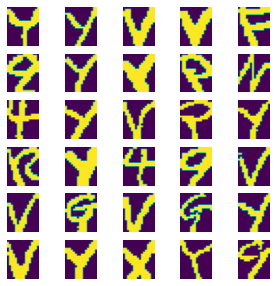

Cluster Number: 22


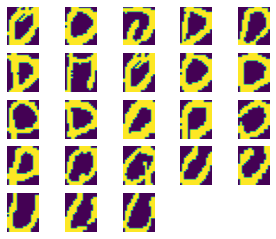

Cluster Number: 31


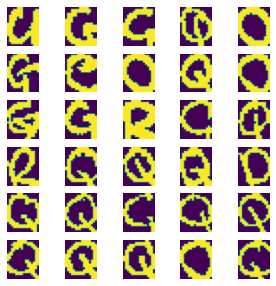

Cluster Number: 33


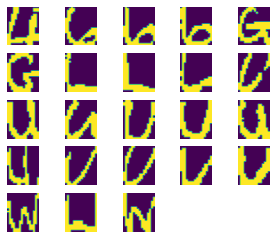

Cluster Number: 0


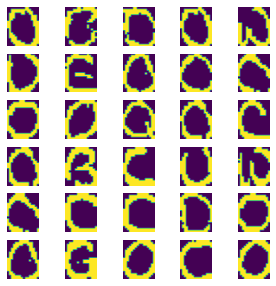

In [7]:
k = 36
init_centroid = get_init_centroid(data, k)
kmeans_clusters = kmeans(data, init_centroid)
view_clusters(images, kmeans_clusters)

## KMEDOIDS

KMEDOIDS performs better because it is less sensitive to outliers than KMEANS. 

In [8]:

def kmedoid(data, init_medoids):
    original_clusters = [[] for i in range(len(init_medoids))]
    while True:
        clusters = [[] for i in range(len(init_medoids))]
        for i, point in enumerate(data):
            d = []
            for c in init_medoids:
                d.append(np.linalg.norm(point - c))
            clusters[np.argmin(d)] += [i]
        sse = 0
        for i in range(len(init_medoids)):
            cluster = [data[p] for p in clusters[i]]
            cdist = matrix_distance(cluster, cluster)
            distances = np.sum(cdist, axis=0)
            c = cluster[np.argmin(distances)]
            init_medoids[i] = c
            c_dist = [np.linalg.norm(data[p] - c) ** 2 for p in clusters[i]]
            sse += np.sum(c_dist)
        # print(clusters, sse, init_centroids)
        if original_clusters == clusters:
            break
        else:
            # print(clusters, sse, init_centroids)
            original_clusters = clusters
    return original_clusters

Cluster Number: 28


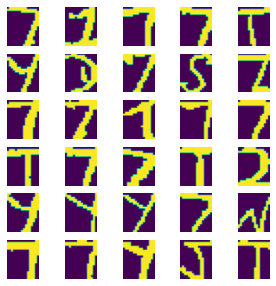

Cluster Number: 17


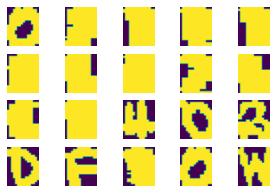

Cluster Number: 33


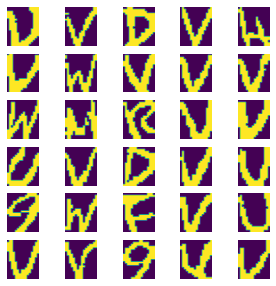

Cluster Number: 12


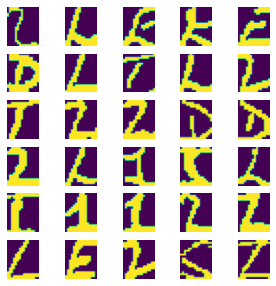

Cluster Number: 14


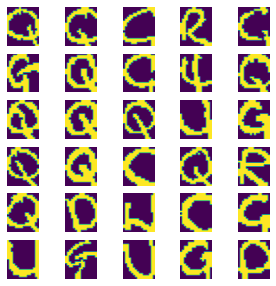

In [9]:
k = 36
init_medoids = get_init_centroid(data, k)
kmedoid_clusters = kmedoid(data, init_medoids)
view_clusters(images, kmedoid_clusters)

## DBSCAN

In [10]:
def create_distance_matrix(data):
    num_examples = data.shape[0]
    distance_matrix = np.zeros((num_examples, num_examples))
    for i, d1 in enumerate(data):
        for j, d2 in enumerate(data):
            distance_matrix[i][j] = np.linalg.norm(d1 - d2)
    return distance_matrix


def add_labels(distance_matrix, eps, minPts):
    num_examples = distance_matrix.shape[0]
    labels = [(None, None) for l in range(num_examples)]
    for i in range(num_examples):
        in_range = {key: dist for key, dist in enumerate(distance_matrix[i]) if dist < eps}
        if len(in_range) > minPts:
            labels[i] = ('core', i)

    for i, l in enumerate(labels):
        if l[0] != 'core':
            in_range = {key: dist
                        for key, dist in enumerate(distance_matrix[i])
                        if dist < eps
                        and labels[key][0] == 'core'
                        and key != i}
            if not in_range:
                labels[i] = ('noise', None)
                continue
            closest = min(in_range, key=in_range.get)
            if closest is not None:
                labels[i] = ('border', closest)
    return labels


def create_clusters(labels, distance_matrix, eps):
    clusters = []
    for i, l in enumerate(labels):
        if l[0] == 'core':
            in_range = {key: dist
                        for key, dist in enumerate(distance_matrix[i])
                        if dist < eps
                        and labels[key][0] == 'core'}
            cluster = set(in_range.keys())
            if not clusters:
                clusters.append(cluster)
                continue
            common_cluster_i = None
            for cl, group in enumerate(clusters):
                if not group.isdisjoint(cluster):
                    common_cluster_i = cl
            if common_cluster_i is not None:
                clusters[common_cluster_i] = clusters[common_cluster_i].union(cluster)
            else:
                clusters.append(cluster)
    for i, l in enumerate(labels):
        if l[0] == 'border':
            in_range = {key: dist
                        for key, dist in enumerate(distance_matrix[i])
                        if dist < eps
                        and labels[key][0] == 'core'
                        and key != i}
            core = min(in_range, key=in_range.get)
            for j, cluster in enumerate(clusters):
                if core in cluster:
                    clusters[j].add(i)

    return clusters

Cluster Number: 4


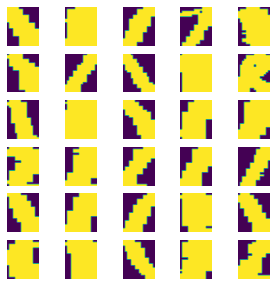

Cluster Number: 16


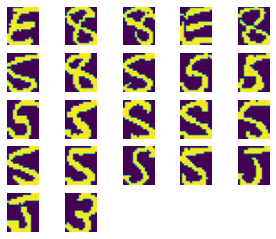

Cluster Number: 0


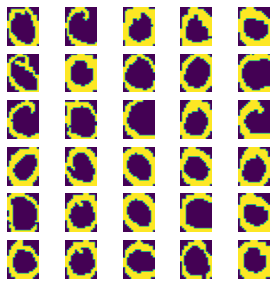

Cluster Number: 23


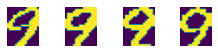

Cluster Number: 12


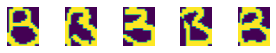

In [11]:
eps = 15
minPts = 3
distance_matrix = matrix_distance(data, data)
labels = add_labels(distance_matrix, eps, minPts)
dbscan_clusters = create_clusters(labels, distance_matrix, eps)
view_clusters(images, dbscan_clusters)

In [12]:
print(f"Number of clusters: {len(dbscan_clusters)}")

Number of clusters: 42


## Hierarchical

In [13]:
def construct_tree(clusters, images, G, num=0):
    root = f"[{num}]"
    G.add_node(root)
    for child in clusters:
        if isinstance(child, int):
            child_node = f"({child})"
            G.add_node(child_node, image=images[child])
        else:
            child_node = f"[{num + 1}]"
            num = construct_tree(child, images, G, num + 1)
        G.add_edge(root, child_node)
    return num

In [14]:
def flatten(list_object, dtype=int):
    _list = []
    for elem in list_object:
        if isinstance(elem, list):
            elem = flatten(elem)
            _list += elem
        elif isinstance(elem, dtype):
            _list.append(elem)
    return _list


def distance_between_cluster(cluster_pair, distance_matrix, type_of_clustering):
    cluster1 = flatten(cluster_pair[0])
    cluster2 = flatten(cluster_pair[1])
    cross_cluster_distances = []
    for i in cluster1:
        for j in cluster2:
            cross_cluster_distances.append(distance_matrix[i][j])
    if type_of_clustering == 'single':
        return min(cross_cluster_distances)
    elif type_of_clustering == 'complete':
        return max(cross_cluster_distances)
    elif type_of_clustering == 'average':
        return np.mean(cross_cluster_distances)


def hierarchical_cluster(distance_matrix, type_of_clustering='single'):
    if type_of_clustering not in ['single', 'complete', 'average']:
        return []
    clusters = [[i] for i in range(len(distance_matrix))]
    while len(clusters) > 2:
        cluster_joins = [list(pair) for pair in combinations(clusters, 2)]
        cluster_distances = [distance_between_cluster(pair, distance_matrix, type_of_clustering)
                             for pair in cluster_joins]
        closest_pair_index = np.argmin(cluster_distances)
        closest_pair = cluster_joins[closest_pair_index]
        clusters = [cluster for cluster in clusters if cluster not in closest_pair]
        clusters.append(closest_pair)

    return clusters

In [15]:
data = normalize(feat, 5)
data = data[:20]

In [16]:
!python -m pip install --global-option=build_ext --global-option="-IC:\Program Files\Graphviz\include" --global-option="-LC:\Program Files\Graphviz\lib" pygraphviz

C:\Users\Ashwin\anaconda3\envs\infrrd\lib\site-packages\pip\_internal\commands\install.py:229: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)


In [17]:
distance_matrix = matrix_distance(data, data)
clusters = hierarchical_cluster(distance_matrix, 'single')
print(clusters)
# G = nx.DiGraph()
# construct_tree(clusters, images[:20], G)

# nx.nx_agraph.write_dot(G, 'test.dot')

# # same layout using matplotlib with no labels
# plt.title('draw_networkx')
# pos = graphviz_layout(G, prog='dot')
# nx.draw(G, pos, with_labels=True, arrows=True)
# plt.show()

[[16], [[[15], [18]], [[[0], [1]], [[[17], [[10], [[19], [[4], [9]]]]], [[[2], [3]], [[13], [[[8], [14]], [[11], [[12], [[5], [[6], [7]]]]]]]]]]]]
